In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import mne
import numpy as np

import os

import matplotlib.pyplot as plt

from sklearn.utils import resample

In [3]:
directory = './eeg-during-mental-arithmetic-tasks-1.0.0/'

rest_filepaths = []
task_filepaths = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if filename.endswith('.edf'):
        label = filename.split('_')[-1].split('.')[0]

        if label == '1':
            rest_filepaths.append(filepath)
        else:
            task_filepaths.append(filepath)

In [4]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split

# Example function to read and process data
def process_data(filepath):
    data = mne.io.read_raw_edf(filepath, preload=True)
    data.set_eeg_reference()
    data.filter(l_freq=0.5, h_freq=45)
    
    min_t, max_t = 0, 61.99
    data.crop(tmin=min_t, tmax=max_t)
    
    tmin, tmax = 0, 1  # Epoch duration of 1 second
    epochs = mne.make_fixed_length_epochs(data, duration=tmax, overlap = 0.5, preload=True)
    
    return epochs

# Function to process all 'task' labeled files
def process_task_files(filepaths):
    epochs_data = []  # List to store epoch data
    labels = []  # List to store corresponding labels
    
    for filepath in filepaths:
        epochs = process_data(filepath)
        epochs_data.extend(epochs.get_data())
        labels.extend([1] * len(epochs))  # Assign label 1 for 'task' (assuming 'task' label)
    
    return np.array(epochs_data), np.array(labels)

def process_rest_files(filepaths):
    epochs_data = []  # List to store epoch data
    labels = []  # List to store corresponding labels
    
    for filepath in filepaths:
        epochs = process_data(filepath)
        epochs_data.extend(epochs.get_data())
        labels.extend([0] * len(epochs))  # Assign label 1 for 'task' (assuming 'task' label)
    
    return np.array(epochs_data), np.array(labels)


In [5]:
%%capture
rest_epochs_data, rest_labels = process_rest_files(rest_filepaths)

task_epochs_data, task_labels = process_task_files(task_filepaths)

In [6]:
rest_epochs_data.shape, task_epochs_data.shape

((4392, 21, 500), (4392, 21, 500))

In [7]:
rest_labels.shape , task_labels.shape

((4392,), (4392,))

In [8]:
epochs_data_combined = np.concatenate([rest_epochs_data, task_epochs_data], axis=0)

# Concatenate labels
labels_combined = np.concatenate([rest_labels, task_labels], axis=0)

# Shuffle (optional)
# Use the same random seed for synchronizing shuffle across data and labels
random_state = 42
np.random.seed(random_state)
shuffle_indices = np.random.permutation(len(labels_combined))
data = epochs_data_combined[shuffle_indices]
label = labels_combined[shuffle_indices]

In [9]:
print("Epochs shape:", data.shape)
print("Labels shape:", label.shape)

Epochs shape: (8784, 21, 500)
Labels shape: (8784,)


In [10]:
# data = np.load('data.npy')
# label = np.load('label.npy')

# # # Convert numpy arrays to PyTorch tensors
# # data = torch.tensor(data, dtype=torch.float32)
# # label = torch.tensor(label, dtype=torch.long)  # Assuming labels are integers (dtype=torch.long)

# # Print shapes to verify
# print("Epochs shape:", data.shape)
# print("Labels shape:", label.shape)

In [11]:
from torch.utils.data import  TensorDataset

# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# # Normalizing Labels to [0, 1, 2, 3]
# y = labels - np.min(labels)
y = label

# Normalizing Input features: z-score(mean=0, std=1)
X = (data - np.mean(data)) / np.std(data)

# Checking the existance of null & inf in the dataset
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    raise ValueError("Data contains NaNs or infinities after normalization.")
if np.any(np.isnan(y)) or np.any(np.isinf(y)):
    raise ValueError("Labels contain NaNs or infinities.")

# Making the X,y tensors for K-Fold Cross Validation
X_tensor = torch.Tensor(X).unsqueeze(1)
y_tensor = torch.LongTensor(y)

# Spliting  Data: 80% for Train and 20% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([7027, 1, 21, 500])
Size of X_test: torch.Size([1757, 1, 21, 500])
Size of y_train: torch.Size([7027])
Size of y_test: torch.Size([1757])


# New Model


### PatchEmbed


In [12]:
import torch
import torch.nn as nn


class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).

    patch_size : int
        Size of the patch (it is a square).

    in_chans : int
        Number of input channels.

    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        # self.n_patches = (img_size // patch_size) ** 2
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x

### Attention


In [13]:
class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors.

    proj_p : float
        Dropout probability applied to the output tensor.


    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x



### MLP


In [14]:
class MLP(nn.Module):
    """Multilayer perceptron.

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU
        GELU activation function.

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x



### Block


In [15]:
class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

### Vision Transformer


In [16]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

### COding


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

custom_config = {
            "img_size":(21,500),
            "patch_size":(1,25),
            "in_chans":1,
            "n_classes":2,
            "embed_dim":768,
            "depth":12,
            "n_heads":12,
            "mlp_ratio":4.,
            "qkv_bias":True,
            "p":0.,
            "attn_p":0.,
}
ViT_model = VisionTransformer(**custom_config).to(device)

In [18]:
random_input = torch.randn(8, 1, 21, 500).to(device)

# Pass the random input through the model to get the output
output = ViT_model(random_input)

# Print the output
print(output.shape)

torch.Size([8, 2])


In [19]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [20]:
# batch_size = 16
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(ViT_model.parameters(), lr=1e-4)


# # Training loop
# num_epochs = 10
# best_test_acc = 0.0

# for epoch in range(num_epochs):
#     ViT_model.train()
#     train_loss = 0.0
#     correct_train = 0

#     for inputs, labels in tqdm(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = ViT_model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(outputs, 1)
#         correct_train += (preds == labels).sum().item()


#     train_loss = train_loss / len(train_loader.dataset)
#     train_acc = correct_train / len(train_loader.dataset)

#     ViT_model.eval()
#     test_loss = 0.0
#     correct_test = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = ViT_model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct_test += (preds == labels).sum().item()
            
            

#     test_loss = test_loss / len(test_loader.dataset)
#     test_acc = correct_test / len(test_loader.dataset)

#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#     # Save checkpoint
#     checkpoint = {
#         'epoch': epoch + 1,
#         'model_state_dict': ViT_model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'train_loss': train_loss,
#         'train_acc': train_acc,
#         'test_loss': test_loss,
#         'test_acc': test_acc
#     }
#     torch.save(checkpoint, f'./results/checkpoint_epoch_{epoch + 1}.pth')

#     # Save best model based on test accuracy
#     if test_acc > best_test_acc:
#         best_test_acc = test_acc
#         torch.save(checkpoint, './results/best_model.pth')

# print("Training complete.")


In [21]:
# Load checkpoint
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViT_model.parameters(), lr=1e-4)
num_epochs = 20

checkpoint = torch.load('./results/best_model.pth')
ViT_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
test_loss = checkpoint['test_loss']
test_acc = checkpoint['test_acc']

print(f"Loaded checkpoint from epoch {start_epoch}")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# # If you want to resume training
# ViT_model.train()

# for epoch in range(num_epochs):
#     ViT_model.train()
#     train_loss = 0.0
#     correct_train = 0

#     for inputs, labels in tqdm(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = ViT_model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(outputs, 1)
#         correct_train += (preds == labels).sum().item()


#     train_loss = train_loss / len(train_loader.dataset)
#     train_acc = correct_train / len(train_loader.dataset)

#     ViT_model.eval()
#     test_loss = 0.0
#     correct_test = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = ViT_model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct_test += (preds == labels).sum().item()
            
            

#     test_loss = test_loss / len(test_loader.dataset)
#     test_acc = correct_test / len(test_loader.dataset)

#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#     # Save checkpoint
#     checkpoint = {
#         'epoch': epoch + 1,
#         'model_state_dict': ViT_model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'train_loss': train_loss,
#         'train_acc': train_acc,
#         'test_loss': test_loss,
#         'test_acc': test_acc
#     }
#     torch.save(checkpoint, f'./results/checkpoint_epoch_{epoch + 1}.pth')

#     # Save best model based on test accuracy
#     if test_acc > best_test_acc:
#         best_test_acc = test_acc
#         torch.save(checkpoint, './results/best_model.pth')

# print("Training complete.")


C:\Users\Atharva\AppData\Local\Temp\ipykernel_42364\4071669316.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./results/best_model.pth')


Loaded checkpoint from epoch 4
Train Loss: 0.6151, Train Accuracy: 0.6556
Test Loss: 0.5592, Test Accuracy: 0.7131


Final Test Loss: 0.5592, Final Test Accuracy: 0.7131


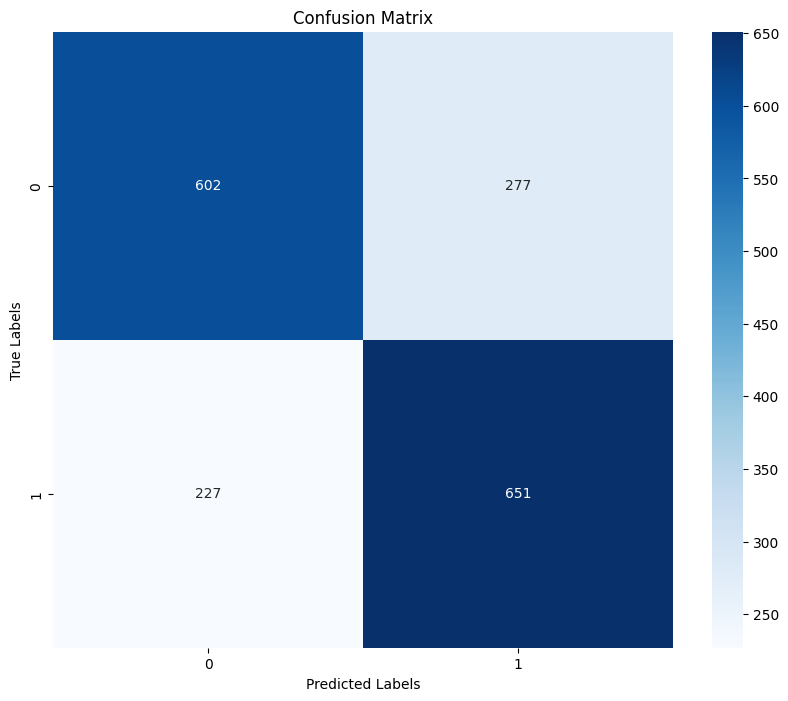

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Evaluate the model on test data and generate confusion matrix
ViT_model.eval()
test_loss = 0.0
correct_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ViT_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = correct_test / len(test_loader.dataset)

print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()